In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
import statsmodels.formula.api as sm
from matplotlib import pyplot as plt
%matplotlib inline

Loading the data and setting hyperparameters

In [2]:
data = pd.read_csv('Melbourne_housing_FULL.csv')

In [3]:
target_column = 'Price'

In [4]:
# hyperparameters
n_estimators = 2
lof_n_neighbors = 20
pca_n_components = 3
n_random_subset = 5
sl_backward_elimination = 0.05

In [5]:
X = data.drop([target_column], axis=1)
y = data[target_column]

# transform categorical variables to numerical variables
le = LabelEncoder()
X['Suburb'] = le.fit_transform(X['Suburb'])
X['Address'] = le.fit_transform(X['Address'])
X['Regionname'] = le.fit_transform([str(rn) for rn in X['Regionname']])
X['CouncilArea'] = le.fit_transform([str(ca) for ca in X['CouncilArea']])
X['SellerG'] = le.fit_transform(X['SellerG'])
X['Type'] = le.fit_transform(X['Type'])
X['Method'] = le.fit_transform(X['Method'])
X['Date'] = [int(d.split('/')[2]) for d in X['Date']]

Choosing the methods for datapreprocessing automatically by a grid-search with MCPS

In [6]:
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)
data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

In [7]:
def adj_r2(y_true, y_pred):
    R2 = metrics.r2_score(y_true, y_pred)
    n = len(y_true)
    p = best_train_data.shape[1] - 1
    return 1-(1-R2)*(n-1)/(n-p-1)

In [8]:
# predict the accuracy of the preprocessed training dataset with a 10-fold cross-validation
def predict_accuracy(dataset_train):
    X, y = getXy(dataset_train)
    regressor = DecisionTreeRegressor(random_state=0)
    cv_results = cross_validate(regressor, X, y, cv=10, scoring=metrics.make_scorer(adj_r2))
    return cv_results['test_score'].mean()

In [9]:
#variables
best_score = 0
best_mcps = []
best_train_data = data_train.copy()
mcps = []
all_scores = {}

In [10]:
def update_score(dataset_train, mcps):
    global best_score, best_mcps, best_train_data, all_scores
    score = predict_accuracy(dataset_train)
    all_scores[score] = mcps
    if score > best_score:
        best_score = score
        best_mcps = mcps
        best_train_data = dataset_train.copy()

In [11]:
def getXy(dataset):
    X_data = dataset.drop([target_column], axis=1)
    y_data = dataset[target_column]
    return X_data, y_data

In [12]:
# handling missing values
# drop rows with missing values
def drop_rows(data_train):
    return data_train.dropna()

# replace missing values with zero
def replace_with_zero(data_train):
    return data_train.fillna(0)

# replace missing values with mean
def replace_with_mean(data_train):
    return data_train.fillna(data_train.mean())

# replace missing values with median
def replace_with_median(data_train):
    return data_train.fillna(data_train.median())

# replace missing values with min
def replace_with_min(data_train):
    return data_train.fillna(data_train.min())

# replace missing values with max
def replace_with_max(data_train):
    return data_train.fillna(data_train.max())

In [13]:
# Outliers
# no outlier handling
def no_outlier_handling(data_train):
    return data_train

# remove outliers with Interquartile Range
def interquartile_range(data_train):
    q25_train = np.percentile(data_train[target_column], 25)
    q75_train = np.percentile(data_train[target_column], 75)
    iqr_train = data_train.drop(data_train[(data_train[target_column] < q25_train) | 
                                           (data_train[target_column] > q75_train)].index, axis=0)
    return iqr_train

# remove outliers with BaggedLOF
def bagged_lof(data_train):
    lof = LocalOutlierFactor(n_neighbors=lof_n_neighbors, contamination=0.1)
    outlier_train_pred = lof.fit_predict(data_train)
    lof_train = data_train.drop(data_train[outlier_train_pred == -1].index, axis=0)
    return lof_train

In [14]:
# Transformation
# no transformation
def no_transformation(data_train):
    return data_train

# normalization
def normalization(data_train):
    normalizer = preprocessing.Normalizer(norm='l2')
    X_train = data_train.drop([target_column], axis=1)
    y_train = data_train[target_column]
    normalized_X_train = pd.DataFrame(normalizer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    normalized_train = pd.concat([normalized_X_train, y_train], axis=1)
    return normalized_train

# standardize
def standardization(data_train):
    standardizer = preprocessing.StandardScaler()
    X_train = data_train.drop([target_column], axis=1)
    y_train = data_train[target_column]
    standardized_X_train = pd.DataFrame(standardizer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    standardized_train = pd.concat([standardized_X_train, y_train], axis=1)
    return standardized_train

In [15]:
# Dimensionality Reduction
# no Dimensionality Reduction
def no_reduction(data_train):
    return data_train

# PCA
def pca(data_train):
    pca = PCA(n_components=pca_n_components)
    X_train = data_train.drop([target_column], axis=1)
    y_train = data_train[target_column]
    pca_X_train = pd.DataFrame(data=pca.fit_transform(X_train), index=X_train.index)
    pca_train = pd.concat([pca_X_train, y_train], axis=1)
    return pca_train
    
# RandomSubset
def random_subset(data_train):
    X_train = data_train.drop([target_column], axis=1)
    y_train = data_train[target_column]
    random_X_train = X_train.sample(n_random_subset, axis=1)
    random_train = pd.concat([random_X_train, y_train], axis=1)
    return random_train

# Backward Elimination
def backward_elimination(data_train):
    X_train = data_train.drop([target_column], axis=1)
    y_train = data_train[target_column]
    numVars = X_train.shape[1]
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
        maxVar = max(regressor_OLS.pvalues)
        if maxVar > sl_backward_elimination:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j] == maxVar):
                    X_train.drop([X_train.columns[j]], axis=1, inplace=True)
    be_train = pd.concat([X_train, y_train], axis=1)
    return be_train

In [16]:
# Grid-search for finding the best mcps
handling_missing_values = [drop_rows, replace_with_zero, replace_with_mean, replace_with_median, replace_with_min, replace_with_max]
handling_outliers = [no_outlier_handling, interquartile_range, bagged_lof]
transformations = [no_transformation, normalization, standardization]
dimensionality_reduction = [no_reduction, pca, random_subset, backward_elimination]
for missing_values_method in handling_missing_values:
    filled_train_data = missing_values_method(data_train)
    print(missing_values_method.__name__)
    for outlier_method in handling_outliers:
        outliers_handled_train_data = outlier_method(filled_train_data)
        for transformation_method in transformations:
            transformed_train_data = transformation_method(outliers_handled_train_data)
            for dim_reduction_method in dimensionality_reduction:
                if dim_reduction_method.__name__ == 'pca' and transformation_method.__name__ == 'no_transformation':
                    continue
                reduced_train_data = dim_reduction_method(transformed_train_data)
                if reduced_train_data.shape[1] > 1:
                    mcps = [missing_values_method.__name__, outlier_method.__name__, transformation_method.__name__,
                            dim_reduction_method.__name__]
                    update_score(reduced_train_data, mcps)

drop_rows


In [17]:
best_mcps

['drop_rows', 'bagged_lof', 'no_transformation', 'backward_elimination']

In [18]:
training_score = best_score
training_score

0.65132111921269042

In [19]:
# all_scores

Making predictions on the preprocessed dataset

In [21]:
def make_prediction(dataset_train, dataset_test):
    X_train, y_train = getXy(dataset_train)
    X_test, y_test = getXy(dataset_test)
    regressor = DecisionTreeRegressor(random_state=0)
    regressor.fit(X_train, y_train)
    pred_test = regressor.predict(X_test)
    return adj_r2(y_test, pred_test), y_test, pred_test

In [22]:
# preprocess the testset in the same way like the trainingset
data_test = locals()[best_mcps[0]](data_test)
data_test = locals()[best_mcps[1]](data_test)
data_test = locals()[best_mcps[2]](data_test)
if (best_mcps[3] == 'backward_elimination'):
    data_test = data_test[best_train_data.columns]
else:
    data_test = locals()[best_mcps[3]](data_test)

In [23]:
test_score, real_test, pred_test = make_prediction(best_train_data, data_test)
test_score

0.64387174445954742

Text(0,0.5,'Predicted Price')

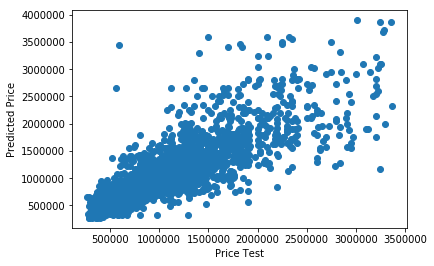

In [24]:
plt.scatter(real_test, pred_test)
plt.xlabel('Price Test')
plt.ylabel('Predicted Price')

Saving the data

In [25]:
pd.DataFrame(pred_test).to_csv('mcps_pred.csv', sep=',', encoding='utf-8', index=None)
pd.DataFrame(real_test).to_csv('mcps_test.csv', sep=',', encoding='utf-8', index=None)